In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import numpy as np


class TSNE:

    def pairwise_distances(self, X):
        """
        input: vectors stored in a N*D array
        output: pairwise eulidean distances in a N*N array

        """
        return np.sum(
            (X[None, :] - X[:, None]) ** 2, 2
        )  # cool trick to perform pairwise euclidean distances calculation using numpu broadcasting rules
        # X[None, :] = X[N, D] -> [1, N, D]
        # X[:, None] = X[N, D] -> [N, 1, D]
        # X[None, :] - X[:, None] = [N, N, D]
        # np.sum((X[None, :] - X[:, None]) ** 2, 2) = [N, N]

    def p_conditional(self, dists, sigmas):
        """
        input:
        dists: N*N array
        sigmas: N*1 array
        output: conditional probabilities p_j|i
        p: N*N array
        """
        e = np.exp(-dists / (2 * np.square(sigmas.reshape((-1, 1)))))
        # e: N*N array
        np.fill_diagonal(e, 0.0)
        e += 1e-8  # for numerical stability
        p = e / e.sum(axis=1).reshape(-1, 1)
        return p

    def _perplexity(self, distribution):
        """
        input:
        distribution: N*N array
        output: perplexity
        """
        exponent = -np.sum(distribution * np.log2(distribution), 1)
        return 2**exponent

    def binary_search(
        self, func, goal, tol=1e-10, max_iterations=1000, lower=1e-20, upper=1e4
    ):
        """
        Perform binary search to find the sigma that results in the desired perplexity
        input:
        func: function
        goal: scalar
        tol: scalar
        max_iterations: scalar
        lower: scalar
        upper: scalar
        output: scalar
        """
        for _ in range(max_iterations):
            guess = (lower + upper) / 2
            out = func(guess)

            if out > goal:
                upper = guess
            else:
                lower = guess

            if np.abs(out - goal) <= tol:
                return guess

        return guess

    def find_sigmas(self, dists, perplexity):
        """
        Find the sigmas for each data point such that the perplexity is equal to the given perplexity
        """
        sigmas = np.zeros(dists.shape[0])

        for i in range(dists.shape[0]):

            func = lambda input: self._perplexity(
                self.p_conditional(dists[i, :], np.array([input]))
            )  # function that compute perplexity starting from distances and sigmas
            sigmas[i] = self.binary_search(
                func, perplexity
            )  # find the sigma that results in the desired value of perplexity

        return sigmas

    def q_joint(self, y):
        """
        input:
        y: N*D array
        output: joint probabilities q_ij
        q: N*N array
        """
        dists = self.pairwise_distances(y)
        # dists: N*N array
        inter = 1 / (1 + dists)
        # inter: N*N array
        np.fill_diagonal(inter, 0.0)

        return inter / np.sum(np.sum(inter))
        # np.sum(np.sum(inter)) = scalar
        # return: N*N array

    def gradient(self, P, Q, y):
        """
        input:
        P: N*N array
        Q: N*N array
        y: N*D array
        output: gradient of the cost function that has dimension N*D

        """
        (n, n_dim) = y.shape
        pq_diff = P - Q
        # pq_diff: N*N array
        y_diff = np.expand_dims(y, 1) - np.expand_dims(y, 0)
        # np.expand_dims(y, 1): N*1*D
        # np.expand_dims(y, 0): 1*N*D
        # y_diff: N*N*D array
        dists = self.pairwise_distances(y)
        # dists: N*N array
        aux = 1 / (1 + dists)
        # aux: N*N array
        return 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux, 2)).sum(1)
        # np.expand_dims(pq_diff, 2): N*N*1
        # y_diff: N*N*D
        # np.expand_dims(pq_diff, 2) * y_diff: N*N*D
        # np.expand_dims(aux, 2): N*N*1
        # (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux, 2)): N*N*D
        # .sum(1): N*D
        # 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux, 2)).sum(1): N*D

    def p_joint(self, X, perplexity):
        """
        calculate the joint probabilities P_ij
        input:
        X: N*D array
        perplexity: scalar
        output: joint probabilities P_ij
        P: N*N array
        """

        n = X.shape[0]
        dists = self.pairwise_distances(X)
        sigmas = self.find_sigmas(dists, perplexity)
        p_cond = self.p_conditional(dists, sigmas)
        return (p_cond + p_cond.T) / (2.0 * n)

    def tsne(self, X, ydim=2, T=1000, l=500, perplexity=20):

        n = X.shape[0]
        P = self.p_joint(X, perplexity)
        # P: N*N array
        y = np.random.normal(loc=0.0, scale=1e-4, size=(n, ydim))
        # y: N*D array

        for t in range(T):
            Q = self.q_joint(y)
            # Q: N*N array
            grad = self.gradient(P, Q, y)
            # grad: N*D array
            y = y - l * grad
            # y: N*D array
            if t % 10 == 0:
                Q = np.maximum(Q, 1e-12)

        return y


In [9]:
tsne = TSNE()

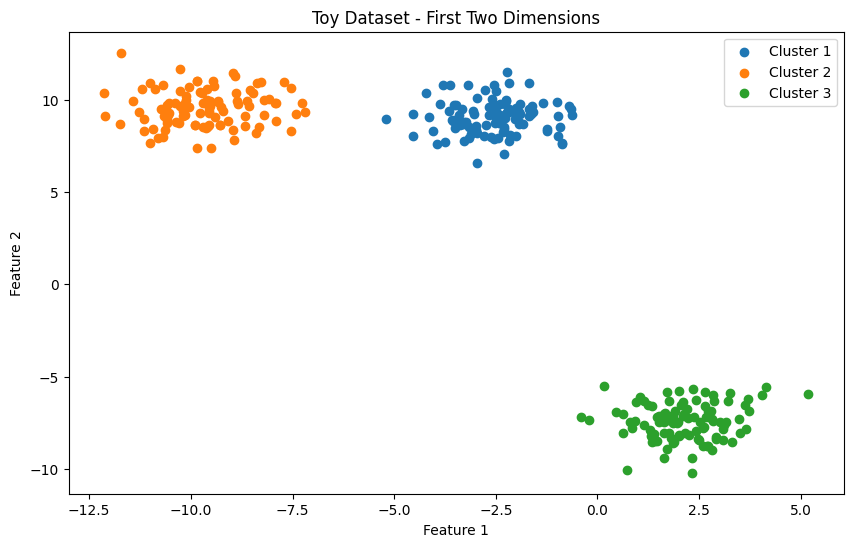

Shape of the dataset: (300, 10)
Number of labels: 3


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Create a toy dataset with 3 blobs
n_samples = 300
n_features = 10
n_centers = 3

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers, random_state=42)

# Visualize the first two dimensions of the dataset
plt.figure(figsize=(10, 6))
for i in range(n_centers):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Cluster {i+1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Toy Dataset - First Two Dimensions')
plt.legend()
plt.show()

print(f"Shape of the dataset: {X.shape}")
print(f"Number of labels: {len(np.unique(y))}")


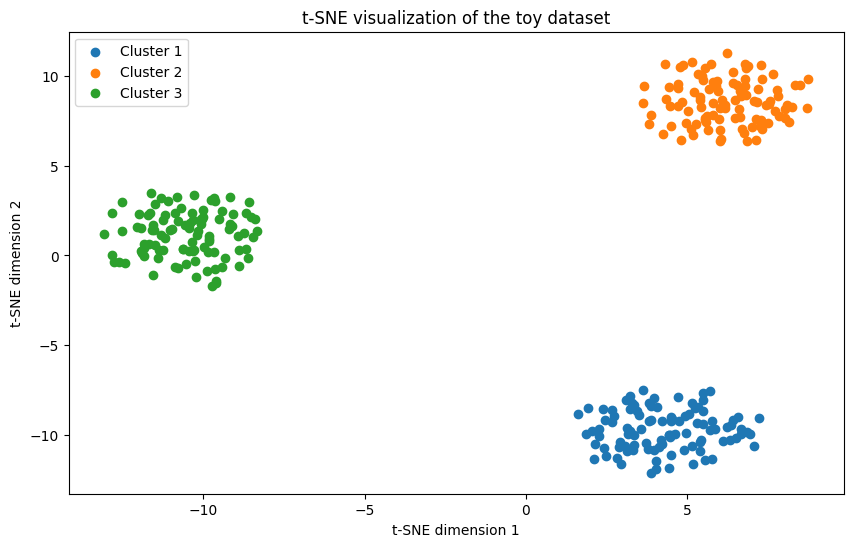

Shape of the t-SNE result: (300, 2)


In [25]:
# Perform t-SNE on the toy dataset
tsne_result = tsne.tsne(X, ydim=2, T=1000, l=200, perplexity=30)

# Visualize the t-SNE result
plt.figure(figsize=(10, 6))
for i in range(n_centers):
    plt.scatter(tsne_result[y == i, 0], tsne_result[y == i, 1], label=f'Cluster {i+1}')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('t-SNE visualization of the toy dataset')
plt.legend()
plt.show()

print(f"Shape of the t-SNE result: {tsne_result.shape}")
